# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.com)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
## Part VI: Portfolio Optimization with Custom Parameters

## 1. Downloading the data:

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets =  ['IEUR', 'IPAC', 'IVV', 'EWC', 'SCZ', 'IJR', 'XCS.TO', 'EIMI.L']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  8 of 8 completed


In [21]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,EIMI.L,EWC,IEUR,IJR,IPAC,IVV,SCZ,XCS.TO
Date,,,,,,,,
2016-01-05,0.8804%,-0.4719%,-0.6498%,0.3069%,0.5109%,0.2079%,-0.2627%,-0.2423%
2016-01-06,-1.1807%,-2.1811%,-1.7442%,-1.1403%,-1.9695%,-1.3091%,-1.6819%,-0.6478%
2016-01-07,-1.9740%,-2.3752%,-1.6741%,-2.5694%,-2.0955%,-2.3928%,-1.5251%,-2.4450%
2016-01-08,-2.0668%,-0.4469%,-1.0557%,-1.6651%,-1.4784%,-1.1077%,-1.3395%,0.0835%
2016-01-11,-0.7576%,-1.3466%,0.1521%,0.0098%,0.1792%,0.1037%,0.1697%,-3.6728%


## 2. Estimating Mean Variance Portfolios with Custom Parameters

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [22]:
import riskfolio.Portfolio as pf

# Building the portfolio object
port = pf.Portfolio(returns=Y)
# Calculating optimum portfolio

# Load our custom estimates of input parameters
custom_mu = pd.read_excel('custom_posterior_mu.xlsx', index_col=0).T
custom_cov = pd.read_excel('custom_posterior_cov.xlsx', index_col=0)

# Input manually the custom parameters:
port.mu = custom_mu # Custom mean vector.
port.cov = custom_cov # Custom covariance matrix.

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,EIMI.L,EWC,IEUR,IJR,IPAC,IVV,SCZ,XCS.TO
weights,1.0755%,16.4315%,44.3784%,8.0852%,0.0000%,0.0000%,0.0000%,30.0294%


### 2.2 Plotting portfolio composition

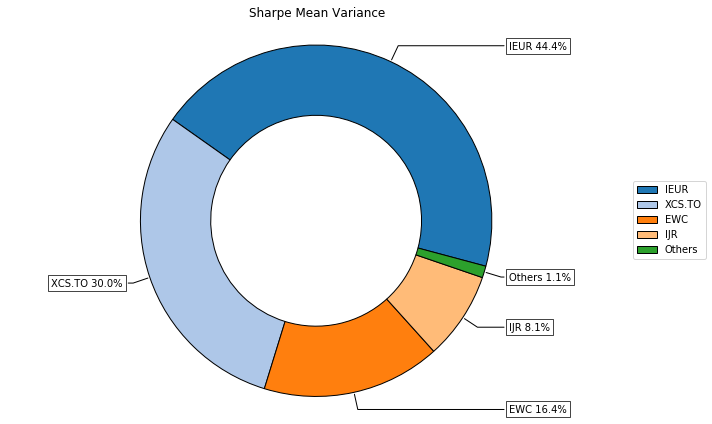

In [23]:
import riskfolio.PlotFunctions as plf

# Plotting the composition of the portfolio

ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

### 2.3 Calculate efficient frontier

In [24]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,EIMI.L,EWC,IEUR,IJR,IPAC,IVV,SCZ,XCS.TO
0,0.0000%,41.5821%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,58.4179%
1,0.0000%,36.3931%,7.7350%,0.5351%,0.0000%,0.0000%,0.0000%,55.3369%
2,0.0000%,33.5421%,13.0804%,1.6838%,0.0000%,0.0000%,0.0000%,51.6937%
3,0.0000%,31.1256%,17.6114%,2.6578%,0.0000%,0.0000%,0.0000%,48.6051%
4,0.0000%,28.9792%,21.6369%,3.5221%,0.0000%,0.0000%,0.0000%,45.8618%


In [25]:
print(port.mu)

           IEUR    IPAC     IVV     EWC     SCZ     IJR  XCS.TO  EIMI.L
Weights 6.3589% 4.5142% 7.2896% 6.7297% 5.7506% 8.4484% 7.2004% 4.6419%


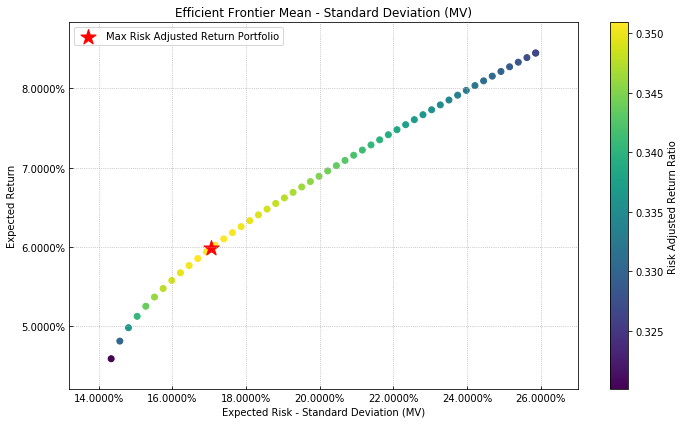

In [26]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

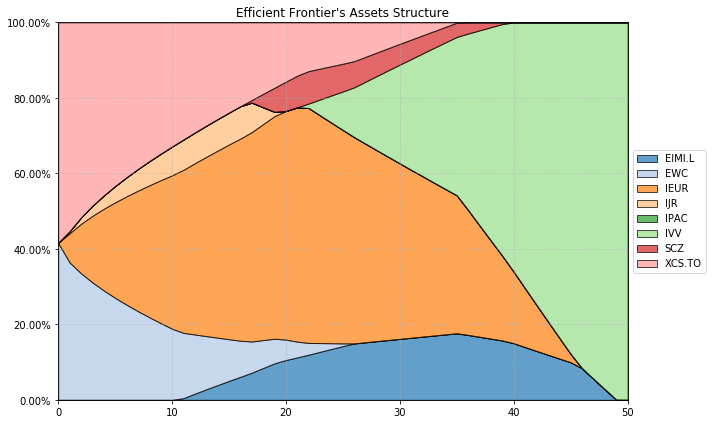

In [27]:
# Plotting efficient frontier composition

ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Mean Risk Portfolios with Custom Mean Parameter

In this part I will calculate optimal portfolios for several risk measures using a custom mean parameter as input. First I'm going to calculate the portfolio that maximizes risk adjusted return when CVaR is the risk measure, then I'm going to calculate the portfolios that maximize the risk adjusted return for all available risk measures.

### 3.1 Calculating the portfolio that maximizes Return/CVaR ratio.

In [28]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,EIMI.L,EWC,IEUR,IJR,IPAC,IVV,SCZ,XCS.TO
weights,20.0537%,0.0000%,0.0000%,0.0000%,0.0000%,48.2100%,0.0000%,31.7363%


### 3.2 Plotting portfolio composition

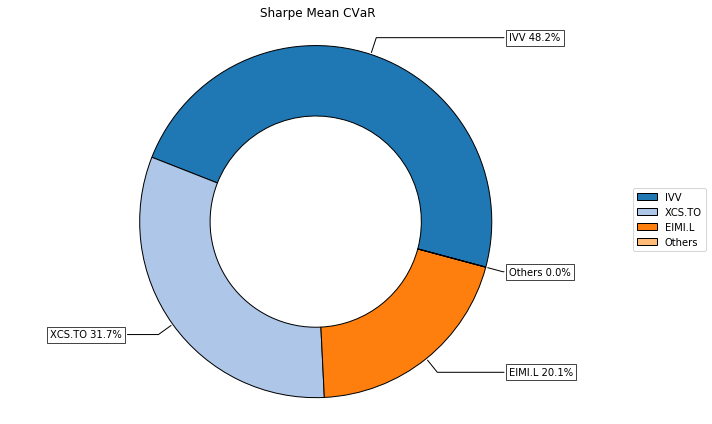

In [29]:
ax = plf.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

### 3.3 Calculate efficient frontier

In [30]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,EIMI.L,EWC,IEUR,IJR,IPAC,IVV,SCZ,XCS.TO
0,28.5700%,0.0000%,0.0000%,7.6017%,15.5558%,0.0000%,0.0000%,48.2725%
1,29.4540%,0.0000%,0.0000%,0.0000%,4.7396%,16.9130%,0.0000%,48.8933%
2,27.4627%,0.0000%,0.0000%,0.0000%,0.0000%,24.4104%,0.0000%,48.1269%
3,21.9661%,0.0000%,0.0000%,0.0000%,0.0000%,30.9298%,0.0000%,47.1041%
4,19.2605%,0.0000%,0.0000%,0.0000%,0.0000%,35.1196%,0.0000%,45.6199%


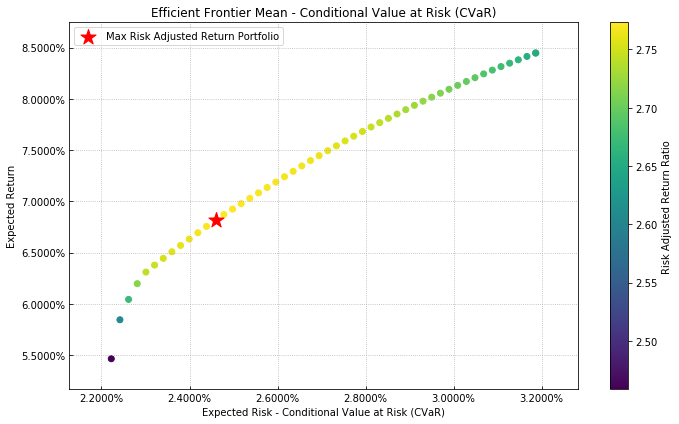

In [31]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

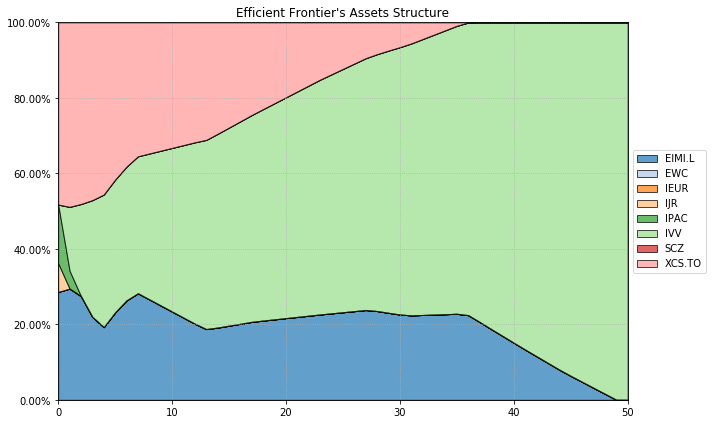

In [32]:
# Plotting efficient frontier composition

ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

### 3.4 Calculate Optimal Portfolios for Several Risk Measures

In [33]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [34]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,WR,MDD,ADD,CDaR
EIMI.L,1.08%,4.84%,4.96%,0.00%,1.54%,20.05%,0.00%,19.63%,0.00%,19.63%
EWC,16.43%,2.68%,2.76%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
IEUR,44.38%,7.65%,7.50%,0.00%,0.00%,0.00%,9.02%,0.00%,0.00%,0.00%
IJR,8.09%,5.49%,5.56%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
IPAC,0.00%,3.90%,4.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
IVV,0.00%,65.37%,65.14%,99.34%,89.98%,48.21%,47.54%,80.37%,100.00%,80.37%
SCZ,0.00%,7.24%,7.15%,0.04%,0.00%,0.00%,1.08%,0.00%,0.00%,0.00%
XCS.TO,30.03%,2.82%,2.90%,0.63%,8.48%,31.74%,42.36%,0.00%,0.00%,0.00%


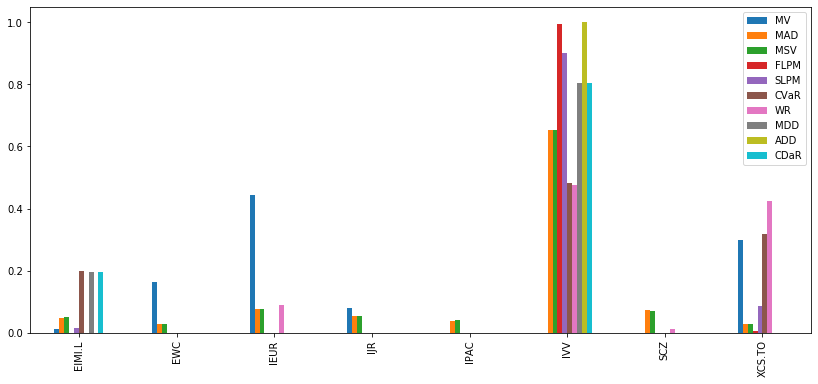

In [35]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)